In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import obonet
from collections import Counter
import wordcloud
import matplotlib.colors as colors
from matplotlib.patheffects import withStroke

print(wordcloud.__version__)

1.9.2


### Load data

In [2]:
data = pd.read_csv('<Path to file containing all significant GO terms when deleted or duplicated>', sep='\t',  encoding='utf-8')
data_clean = data#[data.Catg_TagDS == 0].copy()
print(data_clean.head())
print(data_clean.shape)

  gene_list_name  zTagDS TYPE  Catg_TagDS
0     GO:0000123     NaN  DUP         NaN
1     GO:0000463     NaN  DUP         NaN
2     GO:0000492     NaN  DUP         NaN
3     GO:0001711     NaN  DUP         NaN
4     GO:0001714     NaN  DUP         NaN
(601, 4)


In [3]:
url = 'http://purl.obolibrary.org/obo/go/go-basic.obo'

graph = obonet.read_obo(url)

### Add names to the dataset

In [4]:
data_clean['GO_name'] = data_clean['gene_list_name'].map(lambda x: graph.nodes[x]['name'] if x in graph.nodes else '')
data_clean['GO_type'] = data_clean['gene_list_name'].map(lambda x: graph.nodes[x]['namespace'] if x in graph.nodes else '')

words = ' '.join(data_clean[data_clean.GO_type == 'biological_process']['GO_name'])
stopwords = ['of', 'to', 'via', 'bmp', 'N', 'for', 'in', 'by']  + ['regulation', 'cell', 'protein']

In [5]:
print(Counter(words.split()).most_common(10))
def count_occurrences(text, string_list):
    occurrences = {string: 0 for string in string_list}

    for string in string_list:
        occurrences[string] = text.count(' ' + string + ' ')
    return occurrences

[('of', 178), ('regulation', 163), ('cell', 60), ('to', 42), ('development', 42), ('positive', 41), ('response', 33), ('protein', 30), ('process', 30), ('negative', 30)]


### Prepare wordcloud specific for GO type

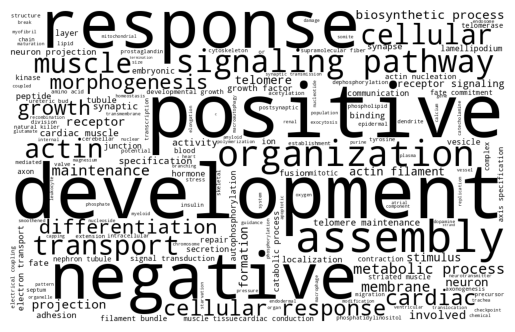

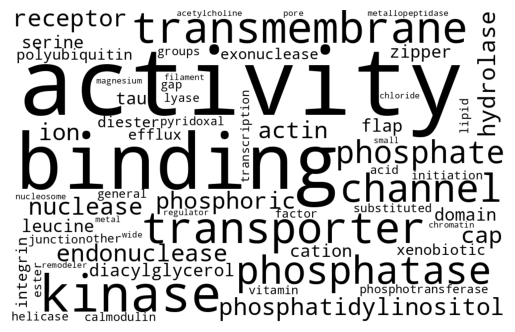

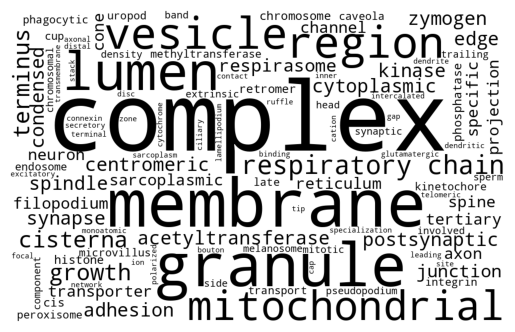

In [6]:
go_majo_words = {}
for GO_type, color in {'biological_process':'crimson', 'molecular_function':'steelblue', 'cellular_component':'mediumseagreen'}.items():
    words = ' '.join(data_clean[data_clean.GO_type == GO_type]['GO_name'])
    wc_tmp = WordCloud(width=1000,
                height=630,
                max_words=200,
                color_func=lambda *args, **kwargs: (0,0,0),
                colormap='coolwarm',
                background_color='white',
                # collocations=False,
                stopwords=stopwords).generate_from_text(words.lower())
    
    list_freq = count_occurrences(words, [k for k,v in wc_tmp.words_.items()])
    wc = WordCloud(width=1000,
                height=630,
                max_words=200,
                color_func=lambda *args, **kwargs: (0,0,0),
                colormap='coolwarm',
                background_color='white',
                # collocations=False,
                ).generate_from_frequencies(list_freq)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
    go_majo_words[color] = [k for k,v in wc.words_.items()]


In [7]:
# kee only unique words in each category
go_majo_words_unique = {}
all_words = []
for k, v in go_majo_words.items():
    all_words += [x for x in v]
print(all_words)
print(Counter(all_words))
reccurent_words = [k for k, v in Counter(all_words).items() if v > 1]
print(reccurent_words)
for k, v in go_majo_words.items():
    go_majo_words_unique[k] = [x for x in v if x not in reccurent_words]

['development', 'positive', 'response', 'negative', 'assembly', 'organization', 'signaling pathway', 'cellular', 'transport', 'muscle', 'actin', 'cellular response', 'cardiac', 'morphogenesis', 'growth', 'differentiation', 'metabolic process', 'maintenance', 'membrane', 'biosynthetic process', 'projection', 'receptor', 'involved', 'neuron', 'telomere', 'actin filament', 'formation', 'stimulus', 'receptor signaling', 'activity', 'cardiac muscle', 'synaptic', 'specification', 'telomere maintenance', 'localization', 'adhesion', 'peptide', 'fusion', 'binding', 'synapse', 'growth factor', 'neuron projection', 'fate', 'tubule', 'ion', 'electron transport', 'layer', 'embryonic', 'repair', 'secretion', 'vesicle', 'junction', 'hormone', 'autophosphorylation', 'lamellipodium', 'communication', 'catabolic process', 'signal transduction', 'filament bundle', 'actin nucleation', 'complex', 'mitotic', 'blood', 'contraction', 'telomerase', 'kinase', 'axon', 'fate commitment', 'nephron tubule', 'muscle

### Create colored wordcloud based on GO type

In [8]:
from wordcloud import (WordCloud, get_single_color_func)
import matplotlib.pyplot as plt


class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func
        print(color_func)
        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)


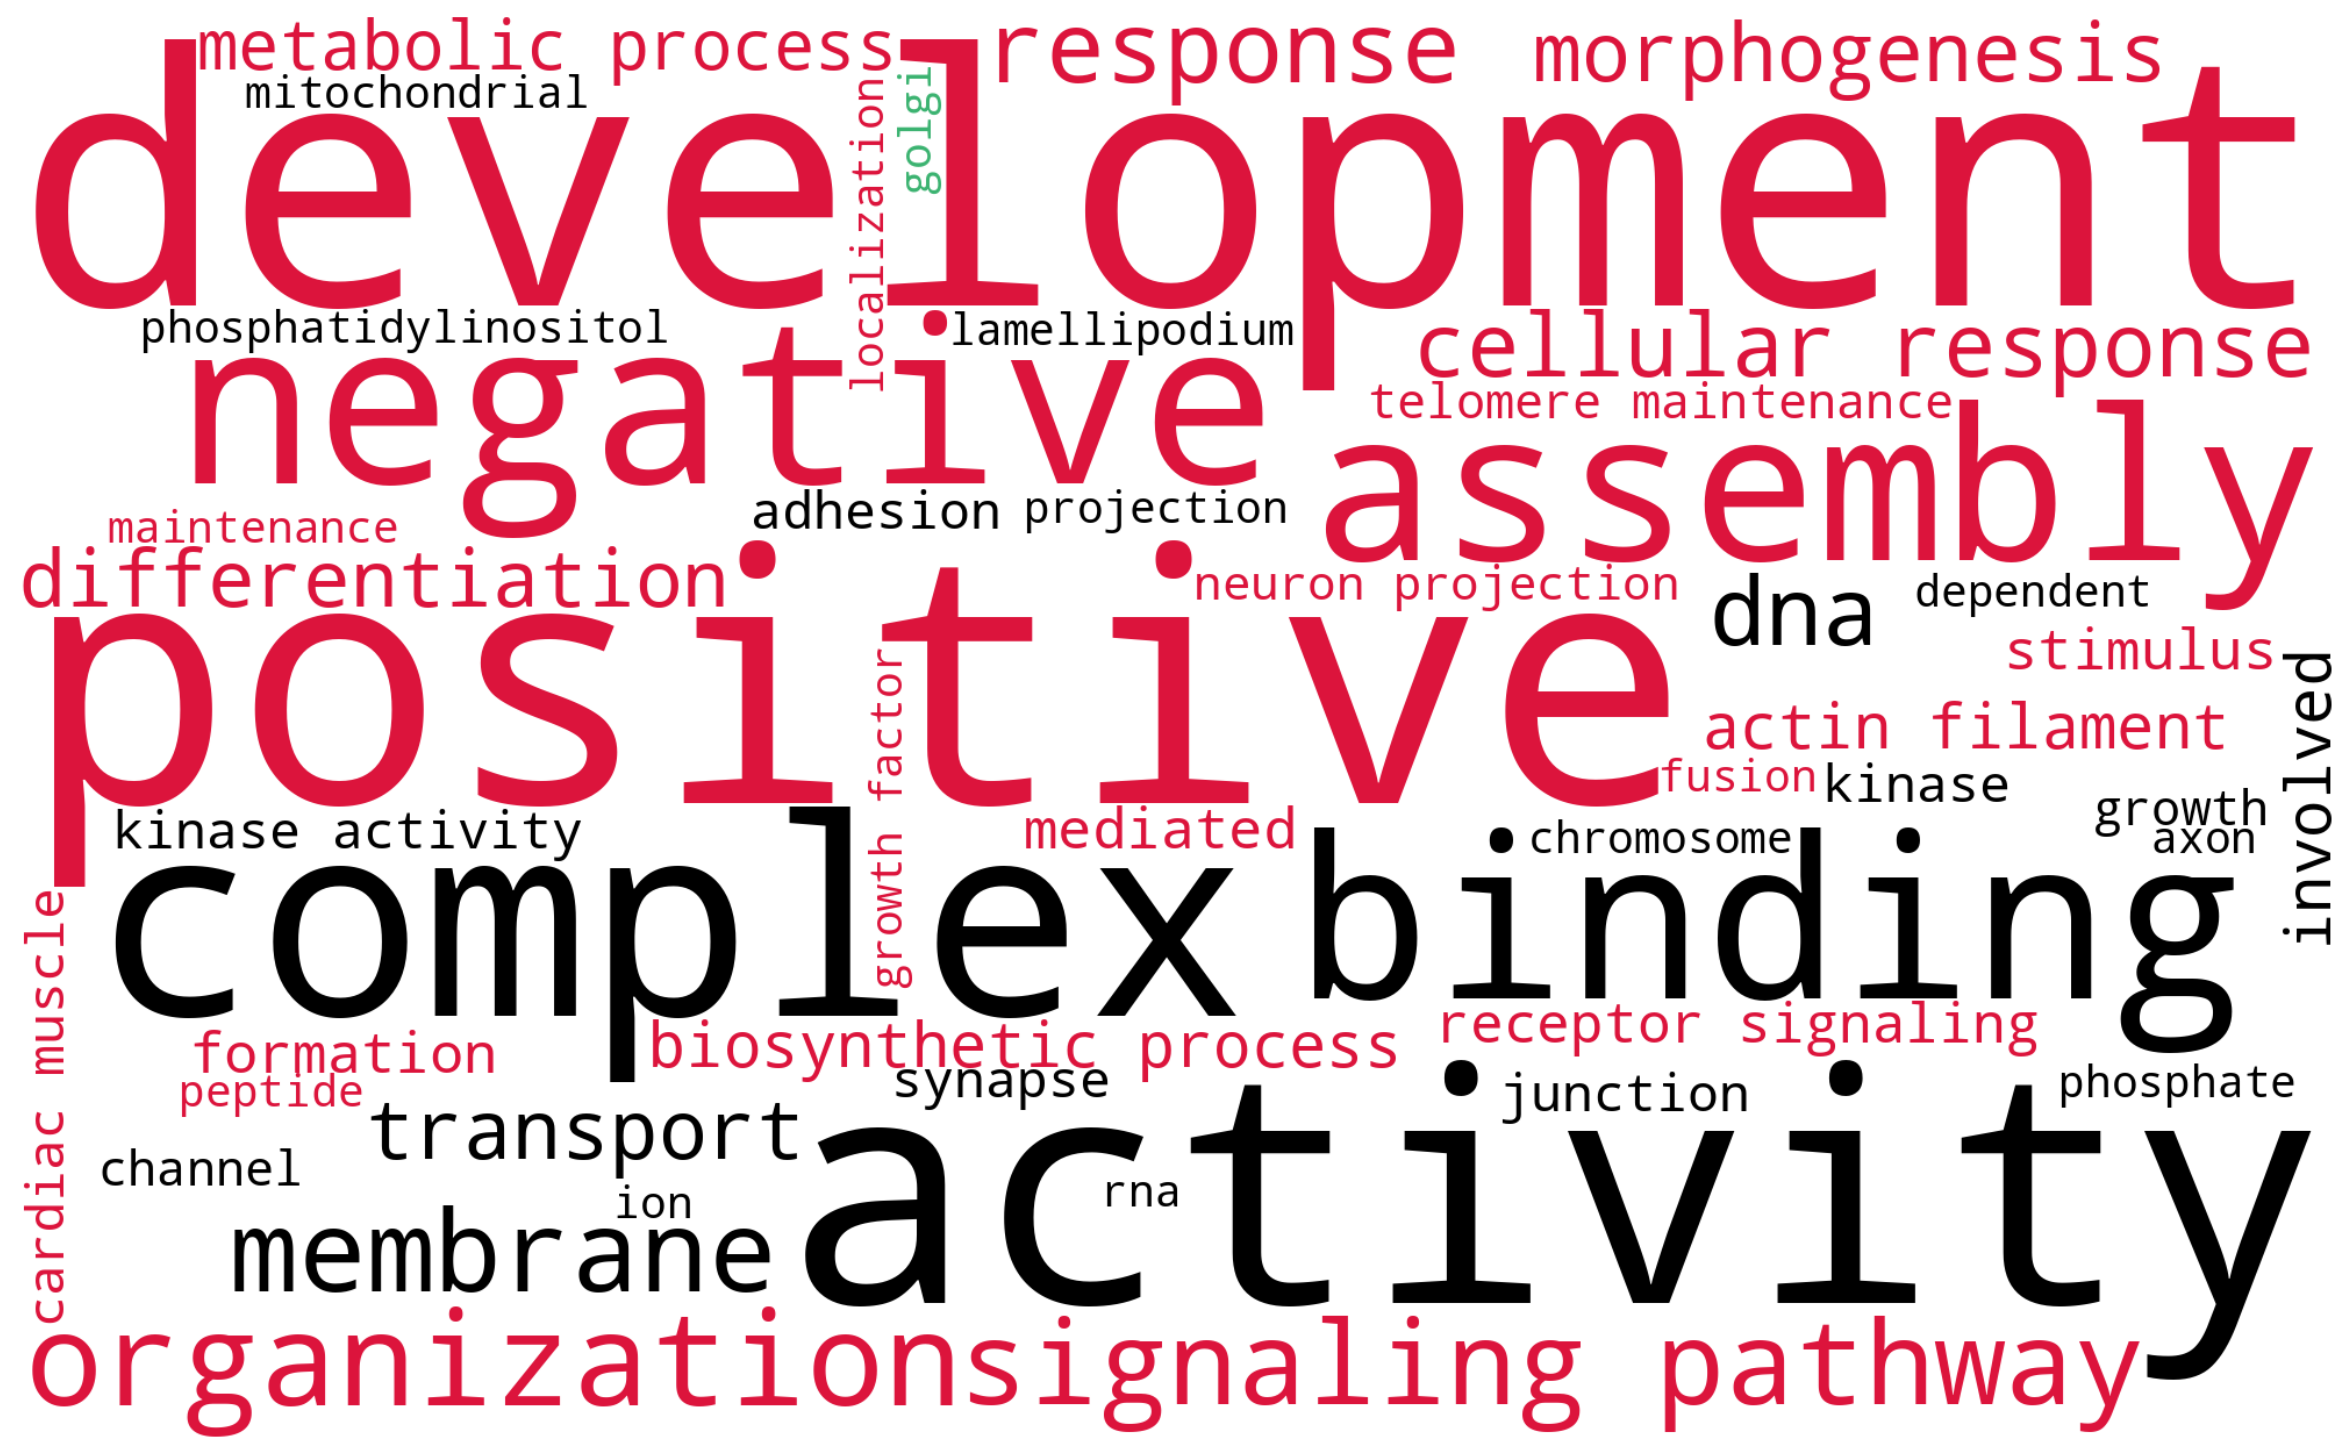

50


In [10]:
words = ' '.join(data_clean['GO_name'])


wc = WordCloud(width=2000,
                height=1230,
                max_words=50,
                colormap='coolwarm',
                background_color='white',
                random_state=42,
                max_font_size=500,
                stopwords=stopwords).generate(words.lower())
default_color = 'black'

list_freq = count_occurrences(words, [k for k,v in wc.words_.items()] + ['cell'])

grouped_color_func = SimpleGroupedColorFunc(go_majo_words_unique, default_color)
# Apply our color function
wc.recolor(color_func=grouped_color_func)

# # Plot
plt.figure(figsize = (30, 30), facecolor = None)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

print(len(wc.words_))

### Create 2 dimensional distribution of words 

In [11]:
words_del = ' '.join(data_clean[data_clean.Catg_TagDS == 1]['GO_name'])
wc = WordCloud(width=2000,
                height=1230,
                max_words=50,
                colormap='coolwarm',
                background_color='white',
                random_state=42,
                max_font_size=500,
                stopwords=stopwords).generate(words_del.lower())

del_df = pd.DataFrame(list(wc.words_.items()), columns=['name', 'freq_del'])

words_dup = ' '.join(data_clean[data_clean.Catg_TagDS == 0]['GO_name'])
wc_dup = WordCloud(width=2000,
                height=1230,
                max_words=50,
                colormap='coolwarm',
                background_color='white',
                random_state=42,
                max_font_size=500,
                stopwords=stopwords).generate(words_dup.lower())

dup_df = pd.DataFrame(list(wc_dup.words_.items()), columns=['name', 'freq_dup'])
all_df = pd.merge(del_df, dup_df, on='name', how='outer')
print(all_df.head())
print(all_df.shape)

          name  freq_del  freq_dup
0     positive      1.00  0.571429
1  development      0.80  0.761905
2      complex      0.60  0.238095
3     assembly      0.60  0.428571
4     activity      0.56  0.809524
(79, 3)


In [12]:
colors_del = plt.cm.Reds(np.linspace(0, 1, 256))
colors_dup = plt.cm.Blues(np.linspace(1, 0, 256))
all_colors = np.vstack((colors_dup, colors_del))
del_dup_spe = colors.LinearSegmentedColormap.from_list('del_dup_spe', all_colors)

number_occurence_max_del = words_del.lower().split().count(del_df.iat[0,0].lower())
print(number_occurence_max_del)
all_df.fillna(0, inplace=True)
all_df['occ_del'] = all_df['freq_del'].map(lambda x: int(x*number_occurence_max_del))

number_occurence_max_dup = words_dup.lower().split().count(dup_df.iat[0,0].lower())
all_df['occ_dup'] = all_df['freq_dup'].map(lambda x: int(x*number_occurence_max_dup))
all_df['ratio_dup'] = all_df['occ_dup']/(all_df['occ_dup'] + all_df['occ_del'])
all_df['occurences'] = all_df['occ_dup'] + all_df['occ_del']
# Create a column with the mean of tagDS for each GOterm comtaining the name
all_df['mean_tagDS'] = all_df['name'].map(lambda x: data_clean[data_clean.GO_name.str.contains(x)]['zTagDS'].mean(skipna=True))
all_df['mean_tagDS'].fillna(0, inplace=True)
all_df = all_df[~all_df['name'].isin(['regulation', 'cell'])]
all_df.reset_index(inplace=True)
print(all_df.head())

25
   index         name  freq_del  freq_dup  occ_del  occ_dup  ratio_dup  \
0      0     positive      1.00  0.571429       25       12   0.324324   
1      1  development      0.80  0.761905       20       16   0.444444   
2      2      complex      0.60  0.238095       15        5   0.250000   
3      3     assembly      0.60  0.428571       15        9   0.375000   
4      4     activity      0.56  0.809524       14       17   0.548387   

   occurences  mean_tagDS  
0          37    0.250127  
1          36    0.270497  
2          20    0.706306  
3          24   -0.022708  
4          31   -0.725152  


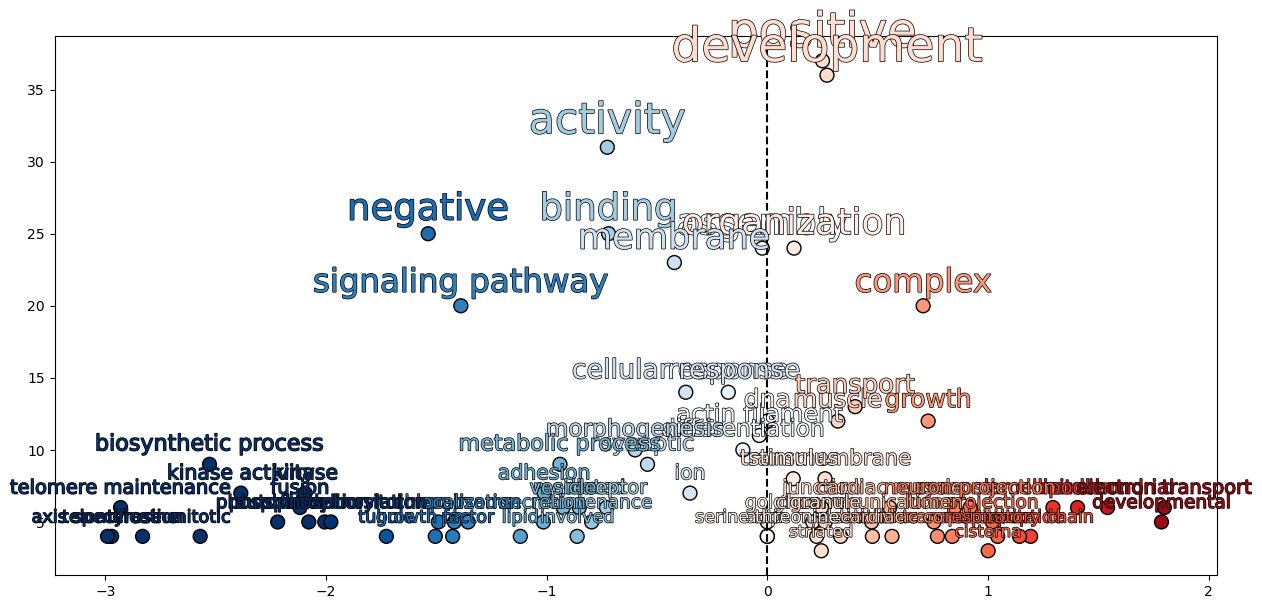

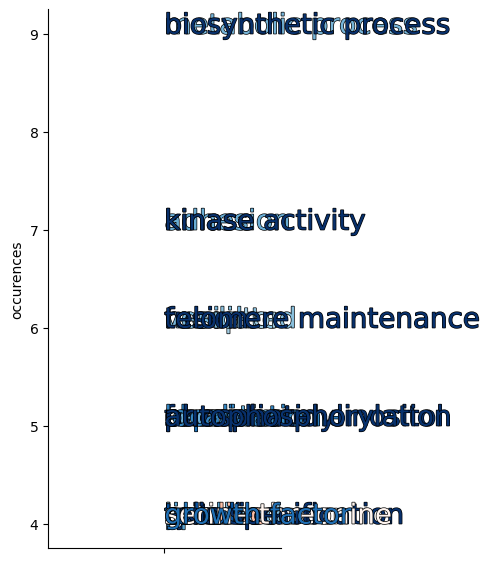

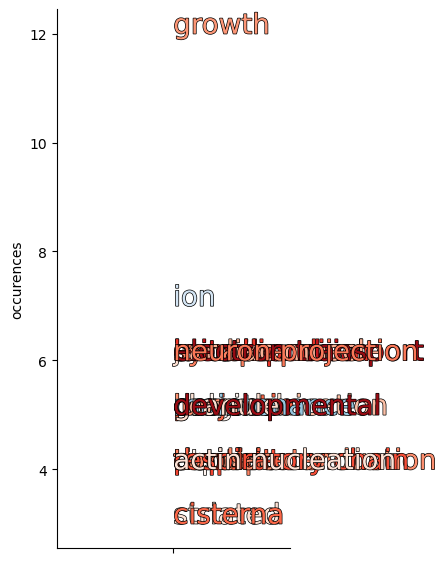

In [17]:
plt.rcParams['svg.fonttype'] = 'none'
plt.figure(figsize = (15, 7), facecolor = None)
scatter = plt.scatter(x=all_df['mean_tagDS'], y=all_df['occurences'], s=100, c=all_df['mean_tagDS'], cmap=del_dup_spe, linewidths=1, edgecolors='black', norm=colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2))
plt.axvline(0, color='black', linestyle='--')
for i, label in enumerate(all_df['name']):
    color = scatter.to_rgba(all_df.loc[i, 'mean_tagDS'])  # Get the color of the corresponding point
    text = plt.annotate(label, (all_df.loc[i,'mean_tagDS'], all_df.loc[i,'occurences']), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10+(all_df.loc[i,'occurences'])/1.5, color=color)
    text.set_path_effects([withStroke(linewidth=1, foreground='black')])

plt.show()

def plot_specific_words(tmp_df):
    tmp_df.reset_index(inplace=True)
    fig,ax = plt.subplots(1,1,figsize=(3,7))
    swarm = sns.swarmplot(data=tmp_df,y='occurences',ax=ax, s=0, c=tmp_df['mean_tagDS'], cmap=del_dup_spe, linewidth=1, edgecolor='black', norm=colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2))
    norm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
    my_round =0 # rounding needed to deal with imperfect precision
    my_dict = {y.round(my_round):x for x,y in ax.collections[0].get_offsets()} # turn array into dict

    for i in tmp_df.index:
        this_label = tmp_df.loc[i,'name']
        this_y = tmp_df.loc[i,'occurences']
        this_x = my_dict[this_y.round(my_round)] # use y-position to get seaborn-generated x-position
        color = plt.cm.get_cmap(del_dup_spe)(norm(tmp_df.loc[i, 'mean_tagDS']))  # Get the color using the colormap
        text = plt.annotate(xy=(this_x,this_y),text=this_label, textcoords="offset points", rotation=0, xytext=(0, 0),  fontsize=20, color=color) # add label
        text.set_path_effects([withStroke(linewidth=1, foreground='black')])

    sns.despine()
    plt.show()

tmp_df = all_df[all_df['ratio_dup']==1]
plot_specific_words(tmp_df)

tmp_df = all_df[all_df['ratio_dup']==0]
plot_specific_words(tmp_df)